In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/EE-411-FOIL-Project/source

/content/drive/MyDrive/EE-411-FOIL-Project/source


# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Import librairies
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
import seaborn as sns
import time

In [ ]:
# Import files
import constants
from models.resnet18k import make_resnet18k
from models.mcnn import make_cnn
from training_utils import*
from functions import*
from display_functions import*

# 1. Data preprocessing

## 1.1 Load data

### 1.1.1 Normal version

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

#### MNIST

In [ ]:
#Train Dataset
MNIST_train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
MNIST_test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

#### CIFAR 10

In [ ]:
#Train Dataset
CIFAR_10_train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_10_test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


#### CIFAR 100

In [ ]:
#Train Dataset
CIFAR_100_train_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

#Test Dataset
CIFAR_100_test_dataset = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### 1.1.2. Augmented version

In [ ]:
transform_augmented_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_augmented_mnist = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

#### MNIST

In [ ]:
#Train Dataset
MNIST_train_dataset_aug = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented_mnist)

#Test Dataset
MNIST_test_dataset_aug = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented_mnist)

#### CIFAR 10

In [ ]:
#Train Dataset
CIFAR_10_train_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented_cifar)

#Test Dataset
CIFAR_10_test_dataset_aug = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented_cifar)

Files already downloaded and verified
Files already downloaded and verified


#### CIFAR 100

In [ ]:
#Train Dataset
CIFAR_100_train_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=True,
    download=True,
    transform=transform_augmented_cifar)

#Test Dataset
CIFAR_100_test_dataset_aug = torchvision.datasets.CIFAR100(
    root='./data/',
    train=False,
    download=True,
    transform=transform_augmented_cifar)

Files already downloaded and verified
Files already downloaded and verified


## 1.3 Vizualize the Dataset

### 1.3.1 Define class dictionaries

In [ ]:
#CIFAR-10
metadata_path = './data/cifar-10-batches-py/batches.meta'
metadata = unpickle(metadata_path)
cifar10_dict = [label.decode('utf-8') for label in metadata[b'label_names']]

#CIFAR-100
metadata_path = './data/cifar-100-python/meta'
metadata = unpickle(metadata_path)
cifar100_dict = [label.decode('utf-8') for label in metadata[b'fine_label_names']]

#### MNIST

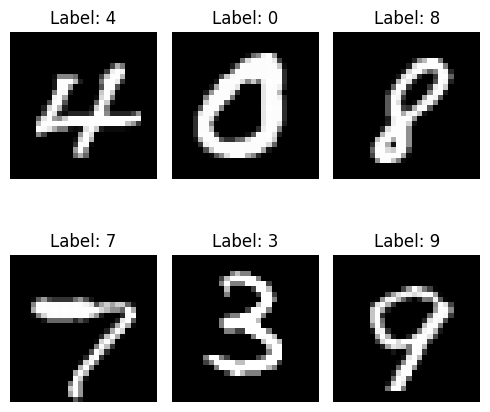

In [ ]:
visualize_dataset((np.array(MNIST_train_dataset.data), np.array(MNIST_train_dataset.targets)), num_images=6)

#### CIFAR 10

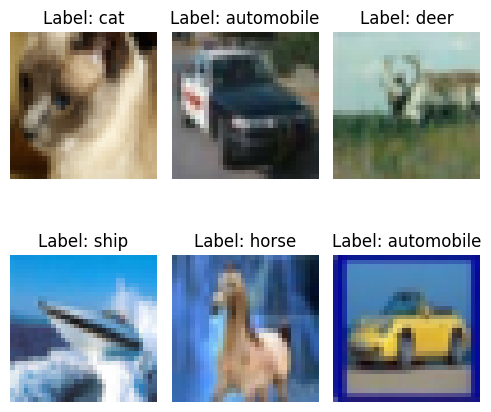

In [ ]:
visualize_dataset((np.array(CIFAR_10_train_dataset.data), np.array(CIFAR_10_train_dataset.targets)), num_images=6,label_names=cifar10_dict)

#### CIFAR 100

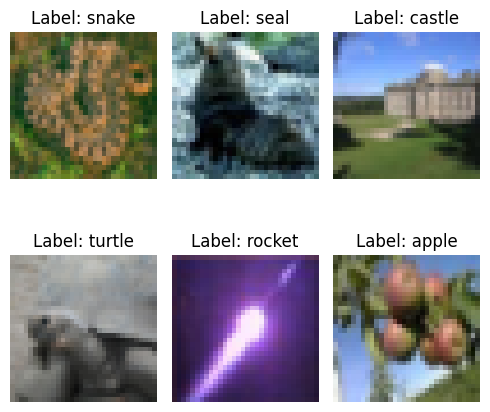

In [ ]:
visualize_dataset((np.array(CIFAR_100_train_dataset.data), np.array(CIFAR_100_train_dataset.targets)), num_images=6,label_names=cifar100_dict)

# 2. Produce Figure 4

## 2.1 MNIST

In [ ]:
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0,0.1,0.2]

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list, width_model_list, MNIST_train_dataset_aug, MNIST_test_dataset_aug)

Model with noise ratio 0


Training for width 64/64

Noise ratio 0 done. Duration: 0:02:02.646543
******************
Model with noise ratio 0.1


Training for width 60/64

In [ ]:
display_error(test_accuracies,width_model_list,noise_ratio_list)

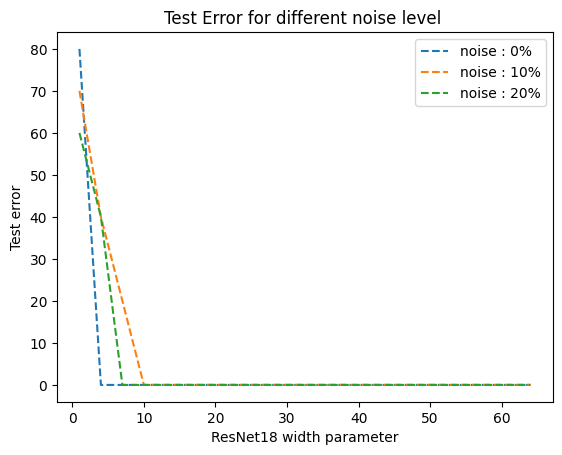

In [ ]:
display_error(train_accuracies,width_model_list,noise_ratio_list)

## Figure 6 : SGD vs Adam
5 Layer CNNs on CIFAR 10, no label noise, no data augmentation, using SGD for 500k gradient step, adam for 4K epochs

In [ ]:
width_model_list = np.linspace(1, 64, 20,dtype=int)


train_losses_Adam = []
train_accuracies_Adam = []
test_losses_Adam = []
test_accuracies_Adam = []

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

subsample_train_indices = torch.randperm(len(CIFAR_10_train_dataset))[:constants.NUM_SAMPLES]

for width in width_model_list :
    cnn_model = make_cnn(c = width)
    cnn = cnn_model.to(constants.DEVICE)
    optimizer_Adam = torch.optim.SGD(cnn.parameters(), lr=constants.Adam_LR)
    losses_Adam = fit(
        model=cnn,
        train_dataloader=CIFAR_10_train_dataloader,
        optimizer=optimizer_Adam,
        epochs=2,
        device=constants.DEVICE
    )
    train_loss_Adam, acc_train_Adam = predict(model=cnn, test_dataloader=CIFAR_10_train_dataloader, device=constants.DEVICE)
    test_loss_Adam, acc_Adam = predict(model=cnn, test_dataloader=CIFAR_10_test_dataloader, device=constants.DEVICE)

    train_losses_Adam.append(train_loss_Adam)
    train_accuracies_Adam.append(acc_train_Adam)

    test_losses_Adam.append(test_loss_Adam)
    test_accuracies_Adam.append(acc_Adam)


    optimizer_SGD = torch.optim.SGD(cnn.parameters(), lr=constants.SGD_LR)
    losses_SGD = fit(
        model=cnn,
        train_dataloader=CIFAR_10_train_dataloader,
        optimizer=optimizer_SGD,
        epochs=2,
        device=constants.DEVICE
    )
    train_loss, acc_train = predict(model=cnn, test_dataloader=CIFAR_10_train_dataloader, device=constants.DEVICE)
    test_loss, acc = predict(model=cnn, test_dataloader=CIFAR_10_test_dataloader, device=constants.DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(acc_train)

    test_losses.append(test_loss)
    test_accuracies.append(acc)


plt.plot(width_model_list, test_losses_Adam, '--',label = 'Test loss with Adam')
plt.plot(width_model_list, test_losses, '--',label = 'Test loss with SGD')
plt.legend()
plt.xlabel('CNN width parameter')
plt.ylabel('Loss')
plt.title('Loss for different width parameter ')
plt.show()